<a href="https://colab.research.google.com/github/pateljay7018/CE888-7-SP-D.S.-and-decision-making-/blob/main/Lab-8/transfer_learning_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import re
import shutil
import os
#os.environ['KAGGLE_USERNAME'] = "jaypatel1298"                  # username from the json file {"username":"jaypatel1298","key":"a045eb4f73821a89322fa5a0689868b4"}
#os.environ['KAGGLE_KEY'] = "a045eb4f73821a89322fa5a0689868b4"   # key from the json file
#!kaggle competitions download -c dogs-vs-cats                  # api copied from kaggle (https://www.kaggle.com/c/dogs-vs-cats/data)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Unzip training data
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [10]:
ls /content/drive/MyDrive/data

cats/  dogs/  horses/  Humans/


In [11]:
path, dirs, files = next(os.walk("/content/drive/MyDrive/data/horses"))
for filename in files:
  new_filename = re.sub("-", ".", filename) 
  os.rename(os.path.join(path, filename), os.path.join(path,new_filename))

path, dirs, files = next(os.walk("/content/drive/MyDrive/data/Humans"))
for filename in files:
  new_filename = re.sub("-", ".", filename) 
  os.rename(os.path.join(path, filename), os.path.join(path,new_filename))

In [12]:
# Make new base directory
original_dataset_dir = '/content/drive/MyDrive/data'
base_dir = '/content/drive/MyDrive/data/animal_small_images'
os.mkdir(base_dir)

In [13]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [14]:
categories = {'cats' : 'cat','dogs': 'dog','horses':'horse','Humans': 'rider' }

for k,v in categories.items():
  path, dirs, files = next(os.walk("/content/drive/MyDrive/data/{}".format(k)))
  # print(path)
  fnamestr = ['{}.{}.jpg'.format(v,i) for i in range(1,int(len(files)*0.7))]
  for fname in fnamestr:
   # print(fname)
    src = os.path.join(path, fname)
    dst = os.path.join(train_dir, fname)
   # print(src,dst)
    shutil.copyfile(src, dst)

  fnamesval = ['{}.{}.jpg'.format(v,i) for i in range(int(len(files)*0.7),int(len(files)*0.85) )]
  for fname in fnamesval:
    src = os.path.join(path, fname)
    dst = os.path.join(validation_dir, fname)
    # print(src,dst)
    shutil.copyfile(src, dst)

  fnameste = ['{}.{}.jpg'.format(v,i) for i in range(int(len(files)*0.85),len(files) )]
  for fname in fnameste:
    src = os.path.join(path, fname)
    dst = os.path.join(test_dir, fname)
    # print(src,dst)
    shutil.copyfile(src, dst)

In [15]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [16]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'cat': return 0    
    elif word_label == 'dog': return 1
    elif word_label == 'horse': return 2
    elif word_label == 'rider': return 3

In [17]:
def createDataSplitSet(datapath):
    X=[]
    y=[]
    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)
    return np.array(X), np.array(y)

In [18]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)

In [19]:
from keras.utils.np_utils import to_categorical   

train_y_ohe = to_categorical(train_y, num_classes=4)
val_y_ohe = to_categorical(val_y, num_classes=4)
test_y_ohe = to_categorical(test_y, num_classes=4)

In [20]:
## InceptionV3
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [21]:
model = InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
model.summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

In [22]:
from keras.layers import Flatten
last_layer = model.get_layer('avg_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(4, activation='softmax', name='output')(x)  # 2 classes
model = Model(img_input, out)

for layer in model.layers[:-3]:
	layer.trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [28]:
model.compile(loss='categorical_crossentropy',optimizer='adamax',metrics=['acc'])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='resnet_model.h5', save_best_only=True), ]

In [30]:
history = model.fit(train_X, train_y_ohe,
                               batch_size=10,
                               epochs=10, 
                               validation_data=(val_X, val_y_ohe),
                               callbacks=my_callbacks)

Epoch 1/10
56/56 [==============================] - 74s 1s/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.1441 - val_acc: 0.9417
Epoch 2/10
56/56 [==============================] - 69s 1s/step - loss: 3.9076e-04 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9750
Epoch 3/10
56/56 [==============================] - 68s 1s/step - loss: 2.3244e-04 - acc: 1.0000 - val_loss: 0.1231 - val_acc: 0.9750
Epoch 4/10
56/56 [==============================] - 67s 1s/step - loss: 1.3848e-04 - acc: 1.0000 - val_loss: 0.1309 - val_acc: 0.9750
Epoch 5/10
56/56 [==============================] - 67s 1s/step - loss: 1.1534e-04 - acc: 1.0000 - val_loss: 0.1328 - val_acc: 0.9750
Epoch 6/10
56/56 [==============================] - 67s 1s/step - loss: 1.3347e-04 - acc: 1.0000 - val_loss: 0.1269 - val_acc: 0.9750
Epoch 7/10
56/56 [==============================] - 67s 1s/step - loss: 8.2185e-05 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9750
Epoch 8/10
56/56 [==============================] - 67s 1s/step - 

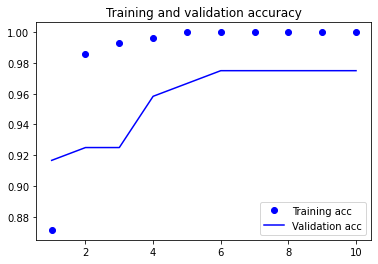

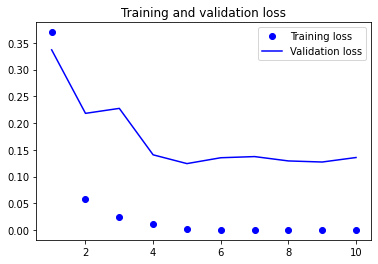

In [26]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y_ohe, ypred)

precision, recall, f1score, _ = precision_recall_fscore_support(test_y_ohe, ypred)

auc = roc_auc_score(test_y_ohe, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", np.mean(precision))
print("Recall:\t\t", np.mean(recall))
print("F1 Score:\t", np.mean(f1score))
print("AUC:\t\t", auc)

Train Accuracy:	 1.0
Val Accuracy:	 0.9750000238418579
Test Accuracy:	 0.9838709677419355
Precision:	 0.9921875
Recall:		 0.9838709677419355
F1 Score:	 0.9876984126984127
AUC:		 0.9905913978494624
